In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pmdarima import auto_arima # np.__version__ could be 1.26.4
from sklearn.metrics import mean_squared_error 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
import warnings

%matplotlib inline

In [2]:
data_path = 'data/avocado.csv'
df = pd.read_csv(data_path)

# Cleanup

In [3]:
df = df.drop('Unnamed: 0', axis = 1)

df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')

**I made a variable df1 where the avocado type is conventional and df2 is organic, because if raw data for any region is put on the graph, it will go in several lines at the same time, This happens because with the same date can go several data while the avocado type can be the same, so to get one row of data, I group the data first by region, then by date**

In [4]:
df1 = df[df.type=='conventional'].groupby(['region', 'Date']).agg({'AveragePrice': 'mean', 'Total Volume': 'mean', '4046': 'mean', '4225': 'mean', '4770': 'mean', 'Total Bags': 'mean', 'Small Bags': 'mean', 'Large Bags': 'mean', 'XLarge Bags': 'mean'}).reset_index()
df2 = df[df.type=='organic'].groupby(['region', 'Date']).agg({'AveragePrice': 'mean', 'Total Volume': 'mean', '4046': 'mean', '4225': 'mean', '4770': 'mean', 'Total Bags': 'mean', 'Small Bags': 'mean', 'Large Bags': 'mean', 'XLarge Bags': 'mean'}).reset_index()

In [5]:
df1['year'] = df1.Date.dt.year
df1['month'] = df1.Date.dt.month
df1['day'] = df1.Date.dt.day

df2['year'] = df2.Date.dt.year
df2['month'] = df2.Date.dt.month
df2['day'] = df2.Date.dt.day

# Top regions by avg price

In [6]:
top_5_avg_price = df.groupby('region')['AveragePrice'].mean().reset_index()
top_5_avg_price = top_5_avg_price.sort_values('AveragePrice', ascending=False)
cheapest_avg_price = top_5_avg_price.tail(1).reset_index()
avg_US_price = top_5_avg_price[top_5_avg_price.region=='TotalUS'][['region', 'AveragePrice']]
top_5_avg_price = top_5_avg_price.head()
combined_avg_price = pd.concat([top_5_avg_price, avg_US_price, cheapest_avg_price])
combined_avg_price = combined_avg_price.reset_index(drop=True)
combined_avg_price = combined_avg_price.drop('index', axis=1)

In [7]:
combined_avg_price

,region,AveragePrice
0,HartfordSpringfield,1.818639
1,SanFrancisco,1.804201
2,NewYork,1.727574
3,Philadelphia,1.632130
4,Sacramento,1.621568
5,TotalUS,1.319024
6,Houston,1.047929


In [8]:
fig = px.bar(combined_avg_price, x= combined_avg_price['region'], y=combined_avg_price['AveragePrice'], title='Regions by average price')
fig.update_layout(xaxis_title='Regions', yaxis_title='Average price')
fig.show()

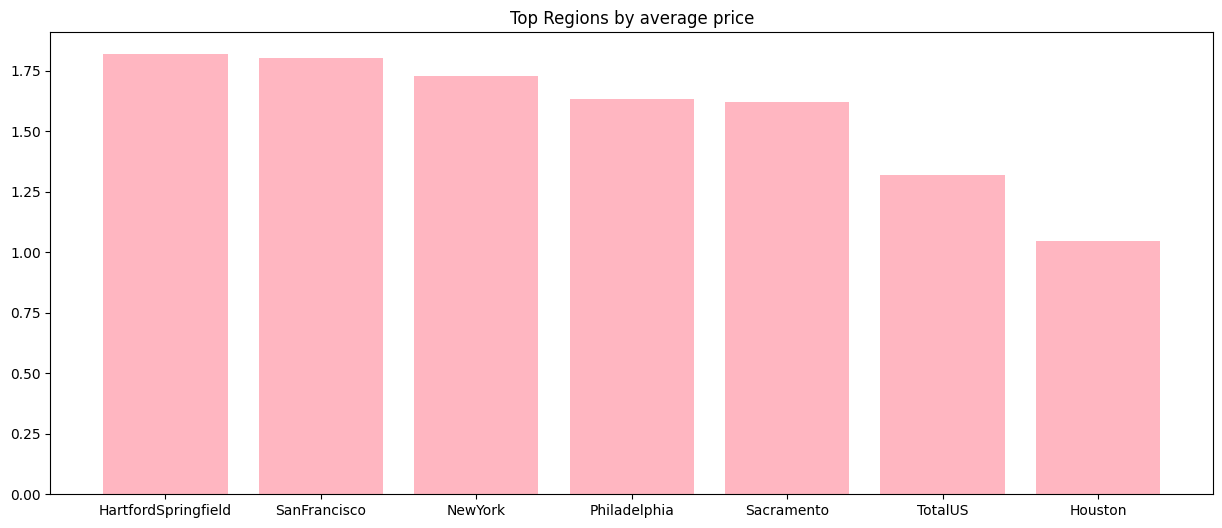

In [9]:
plt.figure(figsize=(15,6))
fig = plt.bar(combined_avg_price['region'], combined_avg_price['AveragePrice'], color='lightpink')
plt.title('Top Regions by average price')
plt.show()

In [10]:
fig = px.bar(combined_avg_price, x= combined_avg_price['region'], y=(combined_avg_price['AveragePrice'] / combined_avg_price['AveragePrice'].max()) * 100, title='Regions by average price in percentage')
fig.update_layout(xaxis_title='Regions', yaxis_title='Percentage (%)')
fig.show()

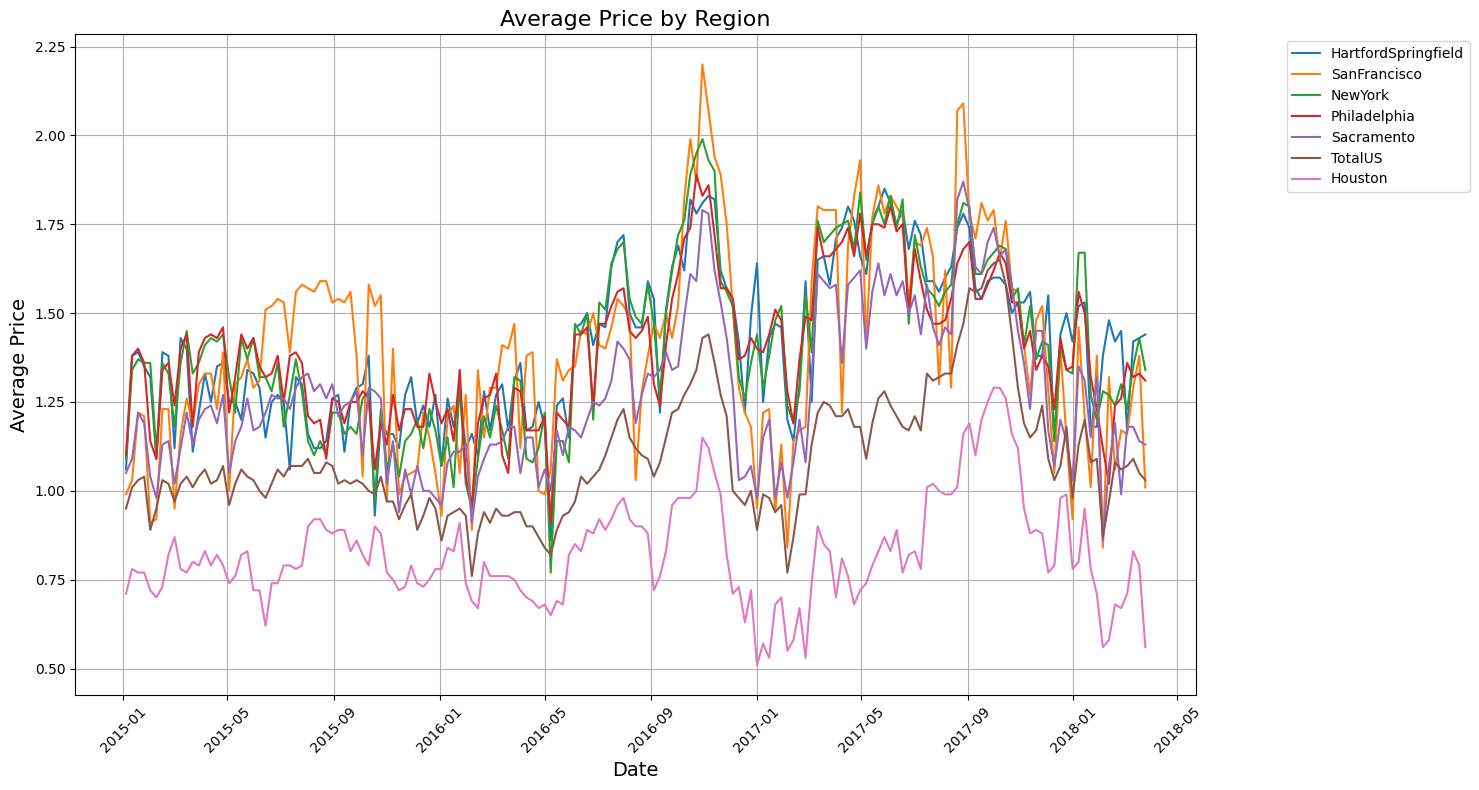

In [11]:
regions = combined_avg_price['region'].unique()
plt.figure(figsize=(15, 8))

for region in regions:
    region_data = df1[df1['region'] == region]
    plt.plot(region_data['Date'], region_data['AveragePrice'], label=region)

plt.title('Average Price by Region', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Price', fontsize=14)

plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.xticks(rotation=45, fontsize=10)
plt.grid()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [12]:
fig = go.Figure()

for i in combined_avg_price.region.unique():
    fig.add_trace(go.Scatter(
            x=df1[df1.region==i]['Date'],
            y=df1[df1.region==i]['AveragePrice'],
            mode='lines',
            hovertemplate="Price: %{y:.2f}",
            name=i
        ))

fig.update_layout(
    width=1100,
    height=600,
    title='Average price by Region',
    xaxis_title='Date',
    yaxis_title='Average Price',
    hovermode="x",
    xaxis_tickformat='%m/%Y',
    xaxis_showgrid=False
)

fig.show()

# Convertional avocados vs organic

In [13]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df1[df1.region == 'TotalUS']['Date'],
                         y=df1[df1.region == 'TotalUS']['AveragePrice'],
                         mode='lines',
                         name='conventional',
                         line=dict(color='#00ffff')))

fig.add_trace(go.Scatter(x=df2[df2.region == 'TotalUS']['Date'],
                         y=df2[df2.region == 'TotalUS']['AveragePrice'],
                         mode='lines',
                         name='organic',
                         line=dict(color='#ffadff')))

fig.update_layout(width=1100,
                  height=600,
                  title='Average price convertional and organic avocados in Total US',
                  plot_bgcolor='#ccf2ff',
                  hovermode="x",
                  paper_bgcolor='white',
                  xaxis_title='Date',
                  yaxis_title='Average Price',
                  xaxis_showgrid=False
)

fig.show()

**Looking at some of the 2015 organic avocado data you can see an omission of values for this period, it would be fair to replace it with the 2015 average as it is now an obvious outlier**

In [14]:
df2.loc[df2['AveragePrice'] == 1, 'AveragePrice'] = df2.loc[df2['year'] == 2015, 'AveragePrice'].mean()

In [15]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df1[df1.region == 'TotalUS']['Date'],
                         y=df1[df1.region == 'TotalUS']['AveragePrice'],
                         mode='lines',
                         name='conventional',
                         line=dict(color='#00ffff')))

fig.add_trace(go.Scatter(x=df2[df2.region == 'TotalUS']['Date'],
                         y=df2[df2.region == 'TotalUS']['AveragePrice'],
                         mode='lines',
                         name='organic',
                         line=dict(color='#ffadff')))

fig.update_layout(width=1100,
                  height=600,
                  title='Average price convertional and organic avocados in Total US',
                  plot_bgcolor='#ccf2ff',
                  hovermode="x",
                  paper_bgcolor='white',
                  xaxis_title='Date',
                  yaxis_title='Average Price',
                  xaxis_showgrid=False
)

fig.show()

In [16]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df1[df1.region == 'TotalUS']['Date'],
                         y=df2[df2.region == 'TotalUS']['AveragePrice']/df1[df1.region == 'TotalUS']['AveragePrice']*100,
                         mode='lines',
                         name='organic/covertional',
                         line=dict(color='#ffadff'),
                         hovertemplate="%{y:.2f}%",))

fig.update_layout(width=1100,
                  height=600,
                  title='How much more expensive are organic avocados than convertional',
                  plot_bgcolor='#ccf2ff',
                  hovermode="x",
                  paper_bgcolor='white',
                  xaxis_title='Date',
                  yaxis_title='Percent',
                  xaxis_showgrid=False
)

fig.show()

# Total US volume organic and convertional avocados

In [17]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df1[df1.region == 'TotalUS']['Date'],
                         y=df1[df1.region == 'TotalUS']['Total Volume'],
                         mode='lines',
                         name='conventional',
                         line=dict(color='#00ffff')))

fig.add_trace(go.Scatter(x=df2[df2.region == 'TotalUS']['Date'],
                         y=df2[df2.region == 'TotalUS']['Total Volume'],
                         mode='lines',
                         name='organic',
                         line=dict(color='#ffadff')))

fig.update_layout(width=1100,
                  height=600,
                  title='Total US volume organic and convertional avocados',
                  plot_bgcolor='#ccf2ff',
                  hovermode="x",
                  paper_bgcolor='white',
                  xaxis_title='Date',
                  yaxis_title='Volume',
                  xaxis_showgrid=False
)

fig.update_xaxes(showspikes=True, spikecolor="gray", spikesnap="cursor", spikemode="across", spikethickness=1.5)
fig.update_layout(spikedistance=1000, hoverdistance=100)

fig.show()

# Total sales from convertional avocados and organic

In [18]:
df1['Income'] = df1['Total Volume']*df1['AveragePrice']
df2['Income'] = df2['Total Volume']*df2['AveragePrice']

In [19]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df1[df1.region == 'TotalUS']['Date'],
                         y=df1[df1.region == 'TotalUS']['Income'],
                         mode='lines',
                         name='conventional',
                         line=dict(color='#00ffff')))

fig.add_trace(go.Scatter(x=df2[df2.region == 'TotalUS']['Date'],
                         y=df2[df2.region == 'TotalUS']['Income'],
                         mode='lines',
                         name='organic',
                         line=dict(color='#ffadff')))

fig.update_layout(width=1100,
                  height=600,
                  title='Total sales from convertional avocados and organic',
                  plot_bgcolor='#ccf2ff',
                  hovermode="x",
                  paper_bgcolor='white',
                  xaxis_title='Date',
                  yaxis_title='Income',
                  xaxis_showgrid=False
)

fig.update_xaxes(showspikes=True, spikecolor="gray", spikesnap="cursor", spikemode="across", spikethickness=1.5)
fig.update_layout(spikedistance=1000, hoverdistance=100)

fig.show()

**Based on the volume and sales we can conclude that the business on organic avocados is only a small niche, which is engaged in by those who are interested and enjoy it, there is not much money to be made on it, even taking into account the price difference between organic and conventional avocados.**

In [20]:
correl_con = df1[['AveragePrice','Total Volume', 'Income']].corr()
correl_org = df2[['AveragePrice','Total Volume', 'Income']].corr()

In [21]:
fig = go.Figure()
fig.add_trace(go.Heatmap(z=correl_con.values, x=list(correl_con.columns), y=list(correl_con.index), colorscale='mint', texttemplate='%{z:.2f}'))
fig.update_layout(title='Convertional avocado correlation', xaxis=dict(side='top'))
fig.show()

In [22]:
fig = go.Figure()
fig.add_trace(go.Heatmap(z=correl_org.values, x=list(correl_org.columns), y=list(correl_org.index), colorscale='mint', texttemplate='%{z:.2f}'))
fig.update_layout(title='Organic avocado correlation', xaxis=dict(side='top'))
fig.show()

**Сorrelation coefficients show that the number of sales depends more on volume than on price.**

# Use the average price of a convertional avocado to find inflation

**Of course it's a joke, we're looking at the relative deviation**

In [23]:
rd = [(n, (df1[df1.year==n]['AveragePrice'].mean()-df1[df1.year==n-1]['AveragePrice'].mean())/df1[df1.year==n]['AveragePrice'].mean()) for n in range(2016, 2019)]

years, ratios = zip(*rd)
ratios = [f"{ratio * 100:.2f}%" for ratio in ratios]

table_data = list(zip(*[years, ratios]))

fig = go.Figure(data=[go.Table(
    header=dict(fill_color='white',
                align='left'),
    cells=dict(values=[['Year','Value']]+table_data,
               fill_color='paleturquoise',
               align='left'))
])

fig.show()

**The average price is gradually rising, although then the price fell again in 2018, but because the data lasts until the uptrend where the price peaks for the year**

# Modeling with SARIMA

In [24]:
regression_data = df1[(df1.region == 'TotalUS') & (df1.year < 2018)][['Date', 'AveragePrice']]
regression_data = regression_data.set_index('Date')

regression_data = regression_data.resample('M').mean()

C:\Users\dhfuc\AppData\Local\Temp\ipykernel_12960\1218694319.py:4: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



I will first try to find the values p,d,q P,D,Q for model manually by brute force search. Here are the best values I got based on the minimum MSE

In [25]:
model = SARIMAX(regression_data,  order = (2, 1, 2), seasonal_order =(1, 0, 0, 12))
result = model.fit()
test_model = result.predict(0, 35)
predictions = result.predict(35, 60)

print('MSE: ',mean_squared_error(regression_data[1:], test_model[1:]))

MSE:  0.009255385207515886


In [26]:
model_df = pd.concat([test_model[1:], regression_data[1:]])
model_df.columns = ['ModelPrice', 'SpecifiedPrice']

In [27]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=model_df.index, y=model_df[model_df['ModelPrice'].isnull()]['SpecifiedPrice'], name="Specified Price", line=dict(color='#00ffff')))
fig.add_trace(go.Scatter(x=model_df.index, y=model_df[model_df['SpecifiedPrice'].isnull()]['ModelPrice'], name="Model price", line=dict(color='#ffadff')))

fig.update_layout(title="Check model price", yaxis_title="Price", width=1100, height=600, plot_bgcolor='#ccf2ff', hovermode="x", paper_bgcolor='white', xaxis_showgrid=False)

fig.show()

In [28]:
prediction_df = pd.concat([predictions, regression_data[1:]])
prediction_df.columns = ['PredictionPrice', 'SpecifiedPrice']

In [29]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=prediction_df[prediction_df['PredictionPrice'].isnull()]['SpecifiedPrice'].index, y=prediction_df[prediction_df['PredictionPrice'].isnull()]['SpecifiedPrice'], name="Specified Price", line=dict(color='#00ffff')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df[prediction_df['SpecifiedPrice'].isnull()]['PredictionPrice'], name="Prediction Price", line=dict(color='#ffadff')))

fig.update_layout(title="Prediction price up to 2020", yaxis_title="Price", width=1100, height=600, plot_bgcolor='#ccf2ff', hovermode="x", paper_bgcolor='white', xaxis_showgrid=False)

fig.show()

The obtained model was well fit to the original data, but there is no pronounced seasonality inherent in the data, so let's try to apply these parameters, found automatically using the auto_arima

In [30]:
warnings.filterwarnings("ignore") 
  
stepwise_fit = auto_arima(regression_data, start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, max_d = 3, m = 12, 
                          start_P = 0, seasonal = True, trace = True, 
                          error_action ='ignore',
                          suppress_warnings = True,
                          stepwise = True)
  
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-18.947, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-19.511, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-16.957, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-17.511, Time=0.24 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-17.511, Time=0.10 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-15.511, Time=0.17 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-21.354, Time=0.10 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-19.354, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-19.354, Time=0.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-17.354, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-19.88

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   36
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  12.677
Date:                            Tue, 24 Dec 2024   AIC                            -21.354
Time:                                    16:58:48   BIC                            -19.083
Sample:                                01-31-2015   HQIC                           -20.783
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5581      0.276     -2.020      0.043      -1.100      -0.017
sigma2         0.0160      0.005      3.313      0.001       0.007       0.025
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 1.65
Prob(Q):                              0.69   Prob(JB):                         0.44
Heteroskedasticity (H):               7.48   Skew:                            -0.53
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
model = SARIMAX(regression_data,  order = (0, 1, 0), seasonal_order =(1, 1, 0, 12))
result = model.fit()
test_model = result.predict(0, 35, type = 'levels')
predictions = result.predict(35, 60, type = 'levels')

mean_squared_error(regression_data[1:], test_model[1:])

0.02013715869714765

The resulting MSE is larger, but let's take a look at the graph

In [32]:
prediction_df = pd.concat([predictions, regression_data[1:]])
prediction_df.columns = ['PredictionPrice', 'SpecifiedPrice']

In [33]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=prediction_df[prediction_df['PredictionPrice'].isnull()]['SpecifiedPrice'].index, y=prediction_df[prediction_df['PredictionPrice'].isnull()]['SpecifiedPrice'], name="Specified Price", line=dict(color='#00ffff')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df[prediction_df['SpecifiedPrice'].isnull()]['PredictionPrice'], name="Prediction Price", line=dict(color='#ffadff')))

fig.update_layout(title="Prediction price up to 2020", yaxis_title="Price", width=1100, height=600, plot_bgcolor='#ccf2ff', hovermode="x", paper_bgcolor='white', xaxis_showgrid=False)

fig.show()

The resulting model more plausibly describes the trend and price movement than the previous one

# Data on US map

**To display the data, we take the most recent year with complete data, 2017**

In [34]:
regions = {
    'Albany': ['NY'],
    'Atlanta': ['GA'],
    'BaltimoreWashington': ['MD', 'DC'],
    'Boise': ['ID'],
    'Boston': ['MA'],
    'BuffaloRochester': ['NY'],
    'California': ['CA'],
    'Charlotte': ['NC'],
    'Chicago': ['IL'],
    'CincinnatiDayton': ['OH'],
    'Columbus': ['OH'],
    'DallasFtWorth': ['TX'],
    'Denver': ['CO'],
    'Detroit': ['MI'],
    'GrandRapids': ['MI'],
    'GreatLakes': ['IL', 'IN', 'MI', 'OH', 'PA'],
    'HarrisburgScranton': ['PA'],
    'HartfordSpringfield': ['CT', 'MA'],
    'Houston': ['TX'],
    'Indianapolis': ['IN'],
    'Jacksonville': ['FL'],
    'LasVegas': ['NV'],
    'LosAngeles': ['CA'],
    'Louisville': ['KY'],
    'MiamiFtLauderdale': ['FL'],
    'Midsouth': ['TN', 'AR', 'MS'],
    'Nashville': ['TN'],
    'NewOrleansMobile': ['LA', 'AL'],
    'NewYork': ['NY'],
    'Northeast': ['CT', 'MA', 'NH', 'NY', 'RI', 'VT'],
    'NorthernNewEngland': ['ME', 'NH', 'VT'],
    'Orlando': ['FL'],
    'Philadelphia': ['PA'],
    'PhoenixTucson': ['AZ'],
    'Pittsburgh': ['PA'],
    'Plains': ['KS', 'OK'],
    'Portland': ['OR'],
    'RaleighGreensboro': ['NC'],
    'RichmondNorfolk': ['VA'],
    'Roanoke': ['VA'],
    'Sacramento': ['CA'],
    'SanDiego': ['CA'],
    'SanFrancisco': ['CA'],
    'Seattle': ['WA'],
    'SouthCarolina': ['SC'],
    'SouthCentral': ['TX', 'OK', 'AR'],
    'Southeast': ['AL', 'FL', 'GA', 'SC'],
    'Spokane': ['WA'],
    'StLouis': ['MO'],
    'Syracuse': ['NY'],
    'Tampa': ['FL'],
    'West': ['CA', 'WA', 'OR'],
    'WestTexNewMexico': ['TX', 'NM']
}
states_price = dict()
states_volume = dict()
states_income = dict()

for i in regions:
    avg_price = df1[(df1.region == i) & (df1.year == 2017)]['AveragePrice'].mean()
    total_volume = df1[(df1.region == i) & (df1.year == 2017)]['Total Volume'].mean()
    income = df1[(df1.region == i) & (df1.year == 2017)]['Income'].mean()
    
    for state in regions.get(i):
        if states_price.get(state):
            states_price[state] = (avg_price + states_price[state]) / 2
        else:
            states_price[state] = avg_price
        if states_volume.get(state):
            states_volume[state] = (total_volume + states_volume[state]) / 2
        else:
            states_volume[state] = total_volume
        if states_income.get(state):
            states_income[state] = (income + states_income[state]) / 2
        else:
            states_income[state] = income

locations = list(states_price.keys())
state_avg_price = list(states_price.values())
state_avg_volume = list(states_volume.values())
state_avg_income = list(states_income.values())

In [35]:
states_price = dict()
states_volume = dict()
states_income = dict()

for i in regions:
    avg_price = df1[(df1.region == i) & (df1.year == 2017)]['AveragePrice'].mean()
    total_volume = df1[(df1.region == i) & (df1.year == 2017)]['Total Volume'].mean()
    income = df1[(df1.region == i) & (df1.year == 2017)]['Income'].mean()
    
    for state in regions.get(i):
        if states_price.get(state):
            states_price[state] = (avg_price + states_price[state]) / 2
        else:
            states_price[state] = avg_price
        if states_volume.get(state):
            states_volume[state] = (total_volume + states_volume[state]) / 2
        else:
            states_volume[state] = total_volume
        if states_income.get(state):
            states_income[state] = (income + states_income[state]) / 2
        else:
            states_income[state] = income

locations = list(states_price.keys())
state_avg_price = list(states_price.values())
state_avg_volume = list(states_volume.values())
state_avg_income = list(states_income.values())

In [54]:
import plotly.express as px

fig = px.choropleth(locations=locations, locationmode="USA-states", color=state_avg_price, scope="usa", color_continuous_scale='blues', 
                    title='Avocado average price by states in 2017',
                    labels={'color':'average price'})
fig.update_layout(margin={"r":25,"t":25,"l":25,"b":25}, width=1000, height=500)
fig.show()

In [53]:
fig = px.choropleth(locations=locations, locationmode="USA-states", color=state_avg_volume, scope="usa", color_continuous_scale='blues', 
                    title='Avocado average volume by states in 2017',
                    labels={'color':'average volume'})
fig.update_layout(margin={"r":25,"t":25,"l":25,"b":25}, width=1000, height=500)
fig.show()

In [52]:
fig = px.choropleth(locations=locations, locationmode="USA-states", color=state_avg_income, scope="usa", color_continuous_scale='blues', 
                    title='Avocado average income by states in 2017',
                    labels={'color':'average income'})
fig.update_layout(margin={"r":25,"t":25,"l":25,"b":25}, width=1000, height=500)
fig.show()

## Top 5 most profitable states:

- California (CA): 4,021,469.12\\$
- Florida (FL): 4,742,379.37\\$
- Texas (TX): 3,909,296.64\\$
- North Carolina (NC): 2,738,206.55\\$
- Illinois (IL): 2,732,206.55\\$
  
**These states are the most profitable for avocado sales. California is especially important given its high consumption rate.**

## Middle-income states:

- New York (NY): 1,829,926.67\\$
- Georgia (GA): 2,666,342.01\\$
- Massachusetts (MA): 3,315,558.25\\$
- Pennsylvania (PA): 2,337,215.75\\$

**These states show stable incomes, which could also make them interesting for further expansion.**

## Low-income states:

Identifying low-income states such as:
- Idaho (ID): 106,302.11\\$
- Kentucky (KY): 111,763.26\\$
- Arkansas (AR): 332,861.17\\$
  
**These states have low potential to market avocados and may require additional marketing efforts to increase interest in the product.**